1A. Explain, in words, how your team will evaluate the success of your robot’s design. This could be by measuring the forces produced by your design, the speed at which it walks, its thrust:weight ratio, the height it can jump, etc. Explain, in words, how you will measure performance in simulation. How will you measure performance in experiments?

The wing’s main objective is to produce positive thrust over the course of a full upstroke and downstroke. However, since we will not be able to isolate the aerodynamic forces from inertial forces and measure the thrust of our prototype, we will mount the wing to a cart, and measure the displacement of the wing after a full cycle. The primary dependent variable is the timing and flapping frequency of the wing. The time that the motor reverses its torque directly affects the aerodynamics of the wing and how much the wing is able to extend and tuck during the downstroke and upstroke. To compare different gait timings, we will divide the displacement by the cycle period and compare the average velocity of each case. The case with the highest average velocity will be our optimal design.

1B. Are experimental vs. simulation metrics similar or vastly different? If different, how will you equate A with B?

By designing our hardware experiment in a measurable way and designing our simulation to emulate the hardware design, our experiment and simulation results should be very similar. In both cases, we will be able to directly control the gait timings and directly measure the displacement of the wing base.

1C. Do you have more than one performance metric you must use as for design goals? If so, either identify the most important one or explain how you will balance two competing criteria. For example, if you need a robot to jump high AND far, which is more important, or how do you establish a relationship between these two possibly competing goals?

The wing is one component of a much larger bird robot. The robot as a whole will have more performance metrics, but our scope is reduced to consider only the design of the wing, and the wing’s primary performance metric is the thrust output. The thrust output is most easily measured using a cart mount and recording the average velocity. There are no competing performance metrics.

1E. Write, in code, a function that will evaluate the performance of your current system (as simulated in System Dynamics II).

Code Below.

2A. Brainstorm and describe your team’s design constraints. Constraints are aspects of your design that are “bounded” by some physical limit (eg, the size of robot you can cut on a given laser cutter, the range of motion of a typical foldable hinge joint).

The independent variable of our experiment is the gait timings. This affects the flapping speed and flapping range of motion. The biggest constraint to the range of motion is the singularities that cause the geometry to invert. The wing must maintain a double concave 2-bar mechanism shape to achieve the tuck and extend motion through its stroke.

2B. Explain, in words, how you will track violation of design constraints. For example, let’s say your optimization routine suggests a design that cannot be made in a single sheet of paper. Will you

The primary violation of our design constraints is a motor command that compromises the geometry of the wing. For example, if one of the strokes is too long, the motor can rotate around too far and invert the wing. Our code will not run through an optimizer. Instead, trials will be run manually, and violations of the constraints will be detected manually by inspection for each trial.



## Setup

In [1]:
#pip install pynamics

In [2]:
%matplotlib inline
import scipy.optimize
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
import pynamics.integration
import numpy
import sympy
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
plt.ion()
from math import pi, sin, cos, tan, asin, acos, atan, degrees, radians, pi, sqrt

## System

In [3]:
# Create a pynamics system
system = System()
pynamics.set_system(__name__,system)

In [4]:
# Length variables (numerical)
lAa_num = 0.05
lAb_num = 0.1
lBa_num = 0.05
lBb_num = 0.1
lC_num = 0.165
lD_num = 0.165
lE_num = 0.045

# Lengths
lAa = Constant(lAa_num,'lAa',system)
lAb = Constant(lAb_num,'lAb',system)
lBa = Constant(lBa_num,'lBa',system)
lBb = Constant(lBb_num,'lBb',system)
lC = Constant(lC_num,'lC',system)
lD = Constant(lD_num,'lD',system)
lE = Constant(lE_num,'lE',system)

In [5]:
# Masses
# r = 149kg/m3
mAa = Constant(0.00447,'mAa',system) # 0.00447000 
mAb = Constant(0.00894,'mAb',system) # 0.00894000 
mBa = Constant(0.00626,'mBa',system) # 0.00625800
mBb = Constant(0.00894,'mBb',system) # 0.00894000 
mC = Constant(0.0148,'mC',system) # 0.01475100
mD = Constant(0.0148,'mD',system) # 0.01475100

mE = Constant(0.2,'mE',system)

# Joint preloads
preload0 = Constant(-120*pi/180,'preload0',system)
preloadA = Constant(0*pi/180,'preloadA',system)
preload1 = Constant(0*pi/180,'preload1',system)
preloadB = Constant(0*pi/180,'preloadB',system)
preload4 = Constant(-90*pi/180,'preload4',system)
preload3 = Constant(-45*pi/180,'preload3',system)

# Inertia
Ixx_Aa = Constant(0.0000336,'Ixx_Aa',system) # 0.00003355
Iyy_Aa = Constant(0.0000373,'Iyy_Aa',system) # 0.00003725
Izz_Aa = Constant(0.0000038,'Izz_Aa',system) # 0.00000375
Ixx_Ab = Constant(0.0000671,'Ixx_Ab',system) # 0.00006710
Iyy_Ab = Constant(0.0000969,'Iyy_Ab',system) # 0.00009685
Izz_Ab = Constant(0.0000299,'Izz_Ab',system) # 0.00002985

Ixx_Ba = Constant(0.0000441,'Ixx_Ba',system) # 0.00004405
Iyy_Ba = Constant(0.0000484,'Iyy_Ba',system) # 0.00004840
Izz_Ba = Constant(0.0000045,'Izz_Ba',system) # 0.00000453
Ixx_Bb = Constant(0.0000671,'Ixx_Bb',system) # 0.00006710
Iyy_Bb = Constant(0.0000969,'Iyy_Bb',system) # 0.00009685
Izz_Bb = Constant(0.0000299,'Izz_Bb',system) # 0.00002985

Ixx_C = Constant(0.0001107,'Ixx_C',system) # 0.00011071
Iyy_C = Constant(0.0002445,'Iyy_C',system) # 0.00024450
Izz_C = Constant(0.000134,'Izz_C',system) # 0.00013394

Ixx_D = Constant(0.0001107,'Ixx_D',system) # 0.00011071
Iyy_D = Constant(0.0002445,'Iyy_D',system) # 0.00024450
Izz_D = Constant(0.0001339,'Izz_D',system) # 0.00013394

In [6]:
# Create differentiable state variables
qx,qx_d,qx_dd = Differentiable('qx',system)

qAa,qAa_d,qAa_dd = Differentiable('qAa',system)
qAb,qAb_d,qAb_dd = Differentiable('qAb',system)

qBa,qBa_d,qBa_dd = Differentiable('qBa',system)
qBb,qBb_d,qBb_dd = Differentiable('qBb',system)

qC,qC_d,qC_dd = Differentiable('qC',system)

qD,qD_d,qD_dd = Differentiable('qD',system)

In [7]:
# initial values
# qC = 11.97 creates fully extended, horizontal wing
initialvalues = {}
initialvalues[qx]=0
initialvalues[qx_d]=0

initialvalues[qAa]=-45*pi/180
initialvalues[qAa_d]=0*pi/180
initialvalues[qAb]=0*pi/180
initialvalues[qAb_d]=0*pi/180

initialvalues[qBa]=0*pi/180
initialvalues[qBa_d]=0*pi/180
initialvalues[qBb]=0*pi/180
initialvalues[qBb_d]=0*pi/180

#initialvalues[qC]=14.65*pi/180
initialvalues[qC]=(-16.69)*pi/180
initialvalues[qC_d]=0*pi/180

initialvalues[qD]=-70.16*pi/180
initialvalues[qD_d]=0*pi/180

In [8]:
# Retrieve state variables in the order they are stored in the system
# Create a list of initial values ini0 in the order of the system’s state variables
statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

In [9]:
# Create frames
N = Frame('N')
Aa = Frame('Aa')
Ab = Frame('Ab')

Ba = Frame('Ba')
Bb = Frame('Bb')

C = Frame('C')
D = Frame('D')

In [10]:
# Declare N as the Newtonian (fixed) frame
system.set_newtonian(N)

In [11]:
# Rotate other frames about their local Z axes.
# Not global q
Aa.rotate_fixed_axis_directed(N,[0,0,1],qAa,system)
Ab.rotate_fixed_axis_directed(Aa,[0,0,1],qAb,system)

Ba.rotate_fixed_axis_directed(Ab,[0,0,1],qBa,system)
Bb.rotate_fixed_axis_directed(Ba,[0,0,1],qBb,system)

C.rotate_fixed_axis_directed(N,[0,0,1],qC,system)
D.rotate_fixed_axis_directed(C,[0,0,1],qD,system)

In [12]:
# Define rigid body kinematics
# position vectors
p0 = qx*N.x #Normal
pA = p0 + lAa*Aa.x #Normal
p1 = pA + lAb*Ab.x #Link A
pB = p1 + lBa*Ba.x #Link A
p2A = pB + lBb*Bb.x #Link B - OUTPUT
p4 = p0 + lE*N.x #Link E
p3 = p4 + lC*C.x #Link C
p2C = p3 + lD*D.x #Link D - OUTPUT

In [13]:
# CoM vectors
pAacom=p0 + lAa/2*Aa.x #Link Aa
pAbcom=pA + lAb/2*Ab.x #Link Ab

pBacom=p1 + 0.0207*Ba.x + 0.00314*Ba.y #Link Ba # 0.02071429x 0.00314286y
pBbcom=pB + lBb*Bb.x #Link Bb

pCcom=p4 + lC/2*C.x #Link Ca
pDcom=p3 + lD/2*D.x #Link Da

pEcom = p0 + lE/2*N.x #Link E

In [14]:
# Angular Velocity
wNAa = N.getw_(Aa)
wAaAb = Aa.getw_(Ab)

wAbBa = Ab.getw_(Ba)
wBaBb = Ba.getw_(Bb)

wNC = N.getw_(C)
wCD = C.getw_(D)

In [15]:
# Build inertia tensors
IAa = Dyadic.build(Aa,Ixx_Aa,Iyy_Aa,Izz_Aa)
IAb = Dyadic.build(Ab,Ixx_Ab,Iyy_Ab,Izz_Ab)

IBa = Dyadic.build(Ba,Ixx_Ba,Iyy_Ba,Izz_Ba)
IBb = Dyadic.build(Bb,Ixx_Bb,Iyy_Bb,Izz_Bb)

IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)
ID = Dyadic.build(D,Ixx_D,Iyy_D,Izz_D)

BodyAa = Body('BodyAa',Aa,pAacom,mAa,IAa,system)
BodyAb = Body('BodyAb',Ab,pAbcom,mAb,IAb,system)

BodyBa = Body('BodyBa',Ba,pBacom,mBa,IBa,system)
BodyBb = Body('BodyBb',Bb,pBbcom,mBb,IBb,system)

BodyC = Body('BodyC',C,pCcom,mC,IC,system)
BodyD = Body('BodyD',D,pDcom,mD,ID,system)
ParticleE = Particle(pEcom,mC,'ParticleE',system)

## Forces

In [16]:
# Motor Torque
t_switch = 0.5
T1 = -0.9
T2 = 0.9
dT = T2-T1

cond = system.t-t_switch
cond_s = (cond+abs(cond))
on = cond_s/(2*cond+1e-4)
system.addforce((dT*on+T1)*N.z,wNAa)

In [17]:
# Spring Forces
kbase = Constant(0.2,'kbase',system) #2.24
kjoint = Constant(0.2,'kjoint',system) #2.24
kbend = Constant(6,'kbend',system) #6
klim = Constant(3,'klim',system) #3

dK = kbase-klim

In [18]:
system.add_spring_force1(kbase,(qAa-preload0)*N.z,wNAa) # qA
system.add_spring_force1(kbend,(qAb-preloadA)*Aa.z,wAaAb)  # virtual A

system.add_spring_force1(dK*on+klim,(qBa-preload1)*Ab.z,wAbBa) # Limiter
#system.add_spring_force1(kbase,(qBa-preload1)*Ab.z,wAbBa) # Limiter Torque off

system.add_spring_force1(kbend,(qBb-preloadB)*Ba.z,wBaBb) # virtual B

system.add_spring_force1(kbase,(qC-preload4)*N.z,wNC) # qC
system.add_spring_force1(kjoint,(qD-preload3)*C.z,wCD) # qD

(<pynamics.force.Force at 0x19aaece3d90>,
 <pynamics.spring.Spring at 0x19aaecba670>)

In [19]:
# Damping
bbase = Constant(0.05,'bbase',system) #1.78
bjoint = Constant(0.05,'bjoint',system) #1.78

In [20]:
system.addforce(-bbase*wNAa,wNAa) # qA
system.addforce(-bjoint*wAbBa,wAbBa) # qB
system.addforce(-bbase*wNC,wNC) # qC
system.addforce(-bjoint*wCD,wCD) # qD

In [21]:
# Aerodynamic Forces
rho = Constant(1.225,'rho',system) # air density
w = Constant(0.15,'w',system) # width or chord length

In [22]:
tolv = 1e-6

In [23]:
# velocity of com
vAacom= pAacom.time_derivative(N,system)
vAacom2= vAacom.dot(vAacom) + tolv
vAbcom= pAbcom.time_derivative(N,system)
vAbcom2= vAbcom.dot(vAbcom) + tolv

vBacom= pBacom.time_derivative(N,system)
vBacom2= vBacom.dot(vBacom) + tolv
vBbcom= pBbcom.time_derivative(N,system)
vBbcom2= vBbcom.dot(vBbcom) + tolv

vCcom= pCcom.time_derivative(N,system)
vCcom2= vCcom.dot(vCcom) + tolv
vDcom= pDcom.time_derivative(N,system)
vDcom2= vDcom.dot(vDcom) + tolv

aero_Aa = rho*abs(vAacom)*w*lAa*vAacom
aero_Aa1 = -aero_Aa
aero_Aa2 = 0*aero_Aa
daero_Aa = aero_Aa2-aero_Aa1
system.addforce((daero_Aa*on+aero_Aa1),vAacom)

aero_Ab = rho*abs(vAbcom)*w*lAb*vAbcom
aero_Ab1 = -aero_Ab
aero_Ab2 = 0*aero_Ab
daero_Ab = aero_Ab2-aero_Ab1
system.addforce((daero_Ab*on+aero_Ab1),vAbcom)

aero_Ba = rho*abs(vBacom)*w*lBa*vBacom
aero_Ba1 = -aero_Ba
aero_Ba2 = 0*aero_Ba
daero_Ba = aero_Ba2-aero_Ba1
system.addforce((daero_Ba*on+aero_Ba1),vBacom)

aero_Bb = rho*abs(vBbcom)*w*lBb*vBbcom
aero_Bb1 = -aero_Bb
aero_Bb2 = 0*aero_Bb
daero_Bb = aero_Bb2-aero_Bb1
system.addforce((daero_Bb*on+aero_Bb1),vBbcom)

aero_C = rho*abs(vCcom)*w*lC*vCcom
aero_C1 = 0*aero_C
aero_C2 = -aero_C
daero_C = aero_C2-aero_C1
system.addforce((daero_C*on+aero_C1),vCcom)

aero_D = rho*abs(vDcom)*w*lD*vDcom
aero_D1 = 0*aero_D
aero_D2 = -aero_D
daero_D = aero_D2-aero_D1
system.addforce((daero_D*on+aero_D1),vDcom)

In [24]:
nvAacom = 1/(vAacom2**.5)*vAacom
aero_Aa = rho*vAacom2*w*lAa*nvAacom
aero_Aa1 = -aero_Aa
aero_Aa2 = 0*aero_Aa
daero_Aa = aero_Aa2-aero_Aa1
system.addforce((daero_Aa*on+aero_Aa1),vAacom)

nvAbcom = 1/(vAbcom2**.5)*vAbcom
aero_Ab = rho*vAbcom2*w*lAb*nvAbcom
aero_Ab1 = -aero_Ab
aero_Ab2 = 0*aero_Ab
daero_Ab = aero_Ab2-aero_Ab1
system.addforce((daero_Ab*on+aero_Ab1),vAbcom)

nvBacom = 1/(vBacom2**.5)*vBacom
aero_Ba = rho*vBacom2*w*lBa*nvBacom
aero_Ba1 = -aero_Ba
aero_Ba2 = 0*aero_Ba
daero_Ba = aero_Ba2-aero_Ba1
system.addforce((daero_Ba*on+aero_Ba1),vBacom)

nvBbcom = 1/(vBbcom2**.5)*vBbcom
aero_Bb = rho*vBbcom2*w*lBb*nvBbcom
aero_Bb1 = -aero_Bb
aero_Bb2 = 0*aero_Bb
daero_Bb = aero_Bb2-aero_Bb1
system.addforce((daero_Bb*on+aero_Bb1),vBbcom)

nvCcom = 1/(vCcom2**.5)*vCcom
aero_C = rho*vCcom2*w*lC*nvCcom
aero_C1 = 0*aero_C
aero_C2 = -aero_C
daero_C = aero_C2-aero_C1
system.addforce((daero_C*on+aero_C1),vCcom)

nvDcom = 1/(vDcom2**.5)*vDcom
aero_D = rho*vBbcom2*w*lD*nvDcom
aero_D1 = 0*aero_D
aero_D2 = -aero_D
daero_D = aero_D2-aero_D1
system.addforce((daero_D*on+aero_D1),vDcom)

## Constraints

In [25]:
# ptipup = 0.547*N.x+0.547*N.y

In [26]:
# Constraints
eq_vector = p2A-p2C
eq = []
eq.append((eq_vector).dot(N.x))
eq.append((eq_vector).dot(N.y))
eq_d=[(system.derivative(item)) for item in eq]
eq_dd=[(system.derivative(item)) for item in eq_d]

eq2_vector = Ab.x-Ba.x
eq2 = []
eq2.append((eq2_vector).dot(N.x))
eq2.append((eq2_vector).dot(N.y))
eq2_d=[(system.derivative(item)) for item in eq2]
eq2_dd=[(system.derivative(item)) for item in eq2_d]

## Solve for valid initial condition

In [27]:
# Declare a list of points that will be used for plotting
points = [p0, pA, p1, pB, p2A, p3, p4]

In [28]:
# Identify independent and dependent variables
qi = [qAa, qC]
qd = [qx, qAb, qBa, qBb, qD]

In [29]:
# Create a copy of symbolic constants dictionary and add the initial value of qi to it
constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

In [30]:
# Substitute constants in equation
eq = [item.subs(constants) for item in eq]
eq2 = [item.subs(constants) for item in eq2]

In [31]:
# Convert to numpy array
# Sum the error
error = (numpy.array(eq)**2).sum() + (numpy.array(eq2)**2).sum()

In [32]:
# Convert to a function that scipy can use.
# Sympy has a “labmdify” function that evaluates an expression, but scipy needs a slightly different format.
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

In [33]:
# Take the derivative of the equations to linearize with regard to the velocity variables
guess = [initialvalues[item] for item in qd]
result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))
ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])
points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]))
#points.plot_time()

2021-04-25 21:26:04,171 - pynamics.output - INFO - calculating outputs
2021-04-25 21:26:04,173 - pynamics.output - INFO - done calculating outputs


array([[[ 0.        ,  0.        ],
        [ 0.03535534, -0.03535534],
        [ 0.10606602, -0.10606602],
        [ 0.14142136, -0.14142136],
        [ 0.21213203, -0.21213203],
        [ 0.20304898, -0.0473869 ],
        [ 0.045     ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.03535534, -0.03535534],
        [ 0.10606602, -0.10606602],
        [ 0.14142136, -0.14142136],
        [ 0.21213203, -0.21213203],
        [ 0.20304898, -0.0473869 ],
        [ 0.045     ,  0.        ]]])

In [34]:
points

In [35]:
result.fun

2.9572202005199067e-10

In [36]:
# Valid initial condition
x = numpy.array([points.y[1][0][0], points.y[1][1][0], points.y[1][2][0], points.y[1][3][0], points.y[1][4][0], points.y[1][5][0], points.y[1][6][0], 0])
y = numpy.array([points.y[1][0][1], points.y[1][1][1], points.y[1][2][1], points.y[1][3][1], points.y[1][4][1], points.y[1][5][1], points.y[1][6][1], 0])
# prettyplot(x,y)

## Solution

In [37]:
# F=ma
f,ma = system.getdynamics()

2021-04-25 21:26:04,234 - pynamics.system - INFO - getting dynamic equations


In [38]:
# Acceleration
func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True)

2021-04-25 21:26:04,875 - pynamics.system - INFO - solving a = f/m and creating function
2021-04-25 21:26:04,888 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-04-25 21:26:42,842 - pynamics.system - INFO - done solving a = f/m and creating function
2021-04-25 21:26:42,842 - pynamics.system - INFO - calculating function for lambdas


In [39]:
# Integration Tolerance
tol = 1e-4

In [40]:
# Time
tinitial = 0
tfinal = 0.9
#tfinal = 4 # torque off
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [41]:
# Integrate
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2021-04-25 21:26:42,890 - pynamics.integration - INFO - beginning integration
2021-04-25 21:26:42,890 - pynamics.system - INFO - integration at time 0000.00
2021-04-25 21:27:38,703 - pynamics.system - INFO - integration at time 0000.50
2021-04-25 21:28:35,177 - pynamics.system - INFO - integration at time 0000.74
2021-04-25 21:28:38,624 - pynamics.integration - INFO - finished integration


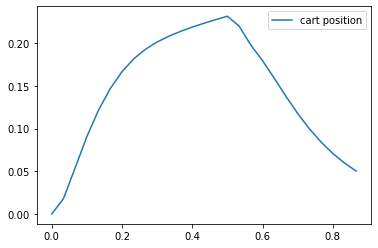

In [42]:
# Outputs
plt.figure()
artists = plt.plot(t,states[:,:1])
plt.legend(artists,['cart position'])

In [43]:
system.get_state_variables()

[qx, qAa, qAb, qBa, qBb, qC, qD, qx_d, qAa_d, qAb_d, qBa_d, qBb_d, qC_d, qD_d]

2021-04-25 21:28:38,788 - pynamics.output - INFO - calculating outputs
2021-04-25 21:28:38,792 - pynamics.output - INFO - done calculating outputs


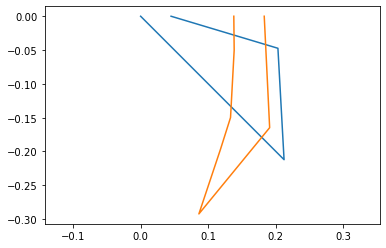

In [44]:
# Motion
points = [p0,pA,p1,pB,p2A,p3,p4]
points_output = PointsOutput(points,system)
y = points_output.calc(states)
points_output.plot_time(20)

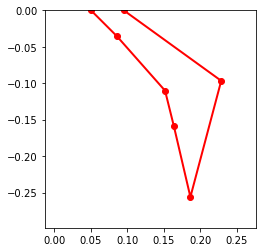

In [45]:
# Motion Animation
points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

In [46]:
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())